In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection  import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
import numpy as np

In [2]:
seed = 123
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)

# 1 Load and Process Data

In [3]:
# Download and preprocess the data
mnist = fetch_openml('mnist_784', version=1)

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
X, y = mnist.data, mnist.target.astype('int64')
X = ((X/255.)-.5)*2

In [5]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.3, random_state=seed)


# Convert to PyTorch tensors and add a dimension to match the CNN input format
X_train_tensor = torch.from_numpy(X_train.values).reshape(-1, 1, 28, 28)
y_train_tensor = torch.from_numpy(y_train.values)
X_test_tensor = torch.from_numpy(X_test.values).reshape(-1, 1, 28, 28)
y_test_tensor = torch.from_numpy(y_test.values)
X_val_tensor = torch.from_numpy(X_val.values).reshape(-1, 1, 28, 28)
y_val_tensor = torch.from_numpy(y_val.values)

In [6]:
print("Train data num:{}".format(X_train.shape[0]))
print("Test data num: {}".format(X_test.shape[0]))
print("Val data num:  {}".format(X_val.shape[0]))

Train data num:56000
Test data num: 9800
Val data num:  4200


In [7]:
# Create datasets and data loaders
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# 2 Create model

In [8]:
import torch.nn.functional as F

# Define the convolutional neural network model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, stride=1)
        self.pool1= nn.MaxPool2d(3,3)
        self.conv2 = nn.Conv2d(6, 10, 3, stride=1)
        self.pool2 = nn.MaxPool2d(3,3)
        
        self.fc1 = nn.Linear(40, 30)  # 5x5 is the size after two max pooling layers
        self.fc2 = nn.Linear(30, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = torch.relu(x)
        
        x = self.conv2(x)
        x = self.pool2(x)
        x = torch.relu(x)
        x = x.view(batch_size, -1)
        
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)

        return x

In [9]:
# Instantiate the model
model = CNN()

# Xavier initialization
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

model.apply(weights_init)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=40, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=10, bias=True)
)

# Train Model

In [10]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
num_epochs = 100
patience = 10
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

best_valid_acc = 0.0
best_model = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)


cuda


In [11]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    total= 0
    for inputs, labels in train_loader:
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        total += len(labels)
        
        _, predicted = torch.max(outputs, 1)
        train_acc += (predicted == labels).sum().item()
        
    train_loss /=  total
    train_acc /= total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    valid_loss = 0.0
    valid_acc = 0.0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.float()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # loss
            valid_loss += criterion(outputs, labels).item()

            # acc
            valid_acc += (predicted == labels).sum().item()
            total += len(predicted)

    valid_loss /= total
    valid_acc /= total
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    print("epoch：{} train loss:{:.4f}  train acc:{:.4f}  val loss: {:.4f} val acc: {:.4f} ".format(epoch, train_loss, train_acc, valid_loss, valid_acc))

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model = model
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement >= patience:
            print(f'Early stopping after {epoch+1} epochs')
            break

    scheduler.step()

    if epoch > 10 and valid_losses[-1] > valid_losses[-2]:
        break

epoch：0 train loss:0.0072  train acc:0.8846  val loss: 0.0038 val acc: 0.9381 
epoch：1 train loss:0.0038  train acc:0.9425  val loss: 0.0040 val acc: 0.9421 
epoch：2 train loss:0.0031  train acc:0.9539  val loss: 0.0041 val acc: 0.9464 
epoch：3 train loss:0.0028  train acc:0.9581  val loss: 0.0036 val acc: 0.9438 
epoch：4 train loss:0.0026  train acc:0.9612  val loss: 0.0028 val acc: 0.9598 
epoch：5 train loss:0.0025  train acc:0.9638  val loss: 0.0033 val acc: 0.9550 
epoch：6 train loss:0.0024  train acc:0.9651  val loss: 0.0022 val acc: 0.9686 
epoch：7 train loss:0.0025  train acc:0.9651  val loss: 0.0025 val acc: 0.9669 
epoch：8 train loss:0.0024  train acc:0.9667  val loss: 0.0026 val acc: 0.9612 
epoch：9 train loss:0.0025  train acc:0.9647  val loss: 0.0024 val acc: 0.9686 
epoch：10 train loss:0.0023  train acc:0.9671  val loss: 0.0026 val acc: 0.9643 
epoch：11 train loss:0.0020  train acc:0.9709  val loss: 0.0026 val acc: 0.9645 


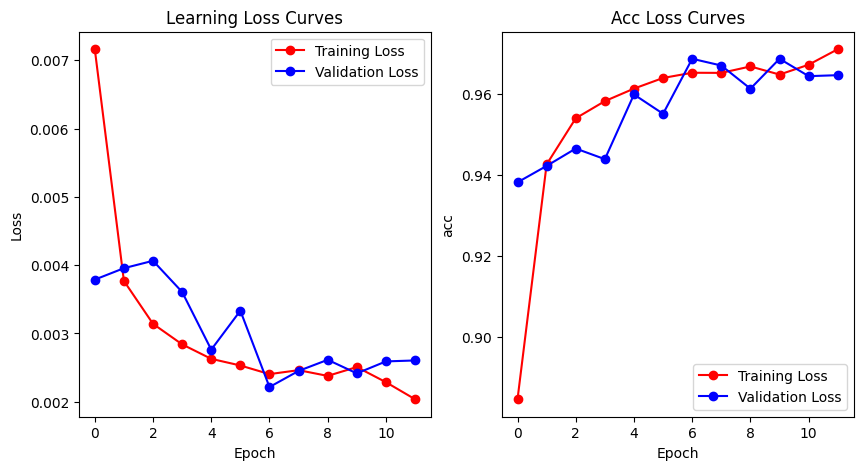

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
# Plot loss  curves
plt.subplot(1, 2, 1) 

plt.plot(train_losses,'ro-', label='Training Loss')
plt.plot(valid_losses,'bo-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Loss Curves')

# Plot loss  curves
plt.subplot(1, 2, 2) 
plt.plot(train_accs,'ro-', label='Training Loss')
plt.plot(valid_accs,'bo-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('acc')
plt.legend()
plt.title('Acc Loss Curves')
plt.show()

Overfitting occurs because the precision of both the training set and the verification set decreases as training increases

# Test model

In [14]:
from sklearn.metrics import confusion_matrix

# Test the model
correct = 0
total = 0
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)
        

        outputs = best_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(f"Test Data Acc : {(100 * correct / total):.2f}%")

Test Data Acc : 96.18%


In [15]:
# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 947    1    3    0    2    2   12    0    0    0]
 [   1 1122    8    0    5    1    1   10    3    1]
 [   8    3  894    2    4    1    0    7   12    2]
 [   7    1    7  923    0   24    0   11   14    5]
 [   0    2    0    0  977    0    1    0    1    3]
 [   4    1    0    1    2  882   12    0    5    1]
 [   2    3    0    0    1    3  917    0    3    0]
 [   2    2   10    2   12    2    0  918    5   10]
 [   9    5    5    1    3   12   11    1  957    7]
 [   1    4    0    1   25   11    0   11   19  889]]


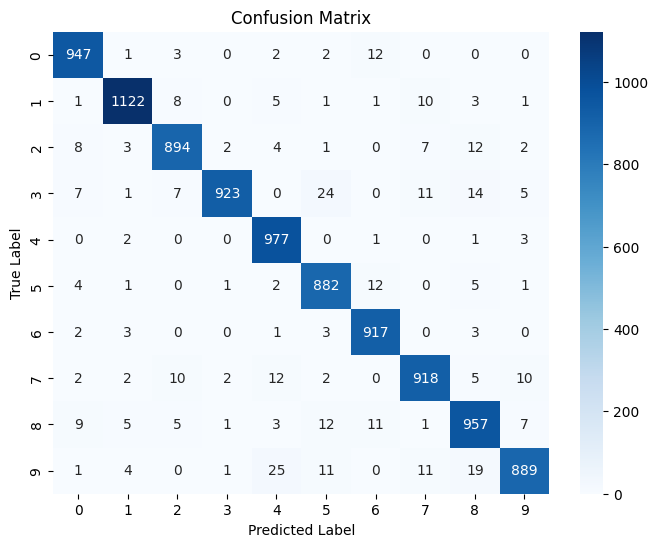

In [16]:
import seaborn as sns

classes = range(10) 
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()